# Every Possible Combination of Attributes: Multiclass Logistic Regression on Iris Data
## Dataset source: http://archive.ics.uci.edu/ml/datasets/Iris

## Inspired by Kevin Markham's "Logistic Regression with Scikit-Learn": http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

### Importing libraries/downloading data

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

We correct a couple of errors in the data (see the source webpage):

In [4]:
iris = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names = ['sepal_L', 'sepal_W', 'petal_L', 'petal_W', 'irisclass'])

iris.at[34, 'petal_W'] = 0.2
iris.at[37, 'sepal_W'] = 3.6
iris.at[37, 'petal_L'] = 1.4

iris.head()

,sepal_L,sepal_W,petal_L,petal_W,irisclass
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Data exploration and visualization:

In [5]:
statsmean = iris.groupby('irisclass').mean()
print(statsmean)
statsdev = iris.groupby('irisclass').std()
print(statsdev)

                 sepal_L  sepal_W  petal_L  petal_W
irisclass                                          
Iris-setosa        5.006    3.428    1.462    0.246
Iris-versicolor    5.936    2.770    4.260    1.326
Iris-virginica     6.588    2.974    5.552    2.026
                  sepal_L   sepal_W   petal_L   petal_W
irisclass                                              
Iris-setosa      0.352490  0.379064  0.173664  0.105386
Iris-versicolor  0.516171  0.313798  0.469911  0.197753
Iris-virginica   0.635880  0.322497  0.551895  0.274650


We'll do some bar plots to get a feel for the data, using a for loop to save us some time.

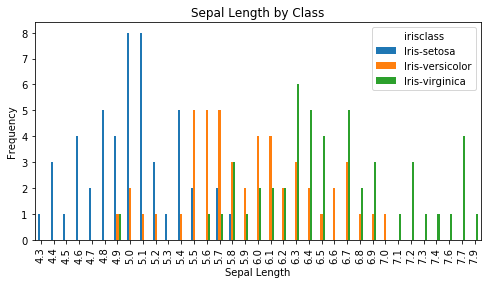

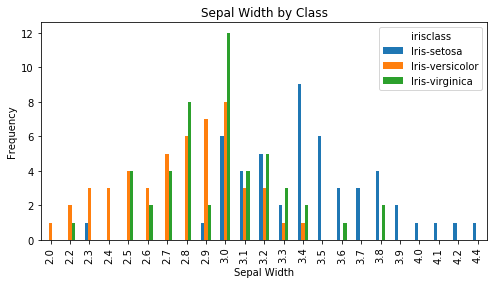

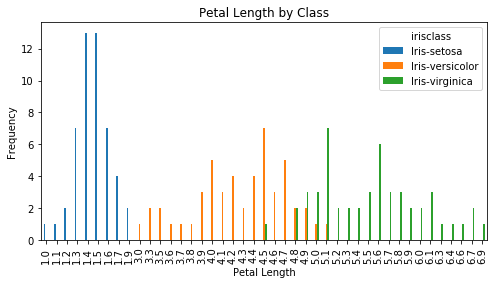

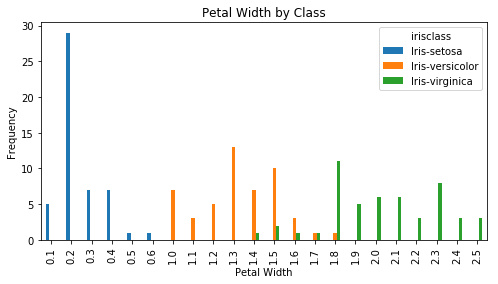

In [6]:
full_labels = {'sepal_L' : 'Sepal Length', 'sepal_W': 'Sepal Width', 'petal_L': 'Petal Length', 'petal_W': 'Petal Width'}

for key, value in full_labels.items():
    pd.crosstab(iris[key], iris['irisclass'].astype('category')).plot(kind='bar', figsize = (8, 4))
    plt.title(value + ' by Class')
    plt.xlabel(value)
    plt.ylabel('Frequency')
    plt.show()

We see from these simple plots that petal width and length are likely to be more useful in our classification problem than sepal length and width, since the ranges of the former two attributes are well-separated compared to the ranges of the latter two.

### Multiclass logistic regression

We now prepare the data and carry out the regression. Note that the default linear solver for binary regression does not work for multiclass regression, so we have to change to another solver.

In [11]:
X = iris[['sepal_L', 'sepal_W', 'petal_L', 'petal_W']]
y = iris['irisclass']

model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
model = model.fit(X, y)

We check the accuracy on the training set:

In [8]:
model.score(X, y)

0.97333333333333338

We evaluate the model using 10-fold cross-validation:

In [9]:
scores = cross_val_score(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg'), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 1.          0.93333333  1.          1.          0.93333333  0.93333333
  0.93333333  1.          1.          1.        ]
0.973333333333


### Regression with every possible combination of attributes

We will now carry out the multiclass regression with every possible combination of attributes and compare the results to see which combination of attributes gives us the most accurate model. For this we need a function to compute the set of all subsets of a given set (AKA its power set), which I found on codereview:

In [10]:
def get_power_set(s):

    power_set = [set()]

    for element in s:
        one_element_set = {element}
        power_set += [subset | one_element_set for subset in power_set]

    return power_set

We use this function to compute a list containing all possible combinations of attributes:

In [10]:
all_attributes = list(map(list, list(get_power_set(set(['sepal_L', 'sepal_W', 'petal_L', 'petal_W'])))))
all_attributes.remove([])

We write and then call a simple function to give us a dataframe containing the results of all the regressions (using 10-fold cross-validation, measured by accuracy).

In [11]:
def all_logits(lis):
    dfr = pd.DataFrame(index = list(map(str, lis)), columns = ['mean score'])
    for i in lis:
        X2 = iris[i]
        dfr.loc[str(i), 'mean score'] = cross_val_score(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg'), X2, y, scoring='accuracy', cv=10).mean()
    return dfr
all_logits(all_attributes)

,mean score
['petal_L'],0.953333
['sepal_W'],0.566667
"['petal_L', 'sepal_W']",0.953333
['sepal_L'],0.753333
"['petal_L', 'sepal_L']",0.96
"['sepal_W', 'sepal_L']",0.806667
"['petal_L', 'sepal_W', 'sepal_L']",0.953333
['petal_W'],0.96
"['petal_L', 'petal_W']",0.96
"['sepal_W', 'petal_W']",0.953333


The results are interesting. We can get very high accuracy just by using a single attribute, petal width. Petal length is another excellent predictor as well. Sepal width and sepal length alone are rather poor predictors. 

All this is consistent with the simple bar plots we did above. For maximal accuracy with the smallest number of predictors, we can use petal length/width together with sepal width. If we wanted to sacrifice a little accuracy, we could get away with just petal length/width.